In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
sess = tf.InteractiveSession()

In [4]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

rnn_weights = tf.Variable(tf.random_normal([n_hidden, n_classes]))
rnn_biases = tf.Variable(tf.random_normal([n_classes]))

In [5]:
def RNN(x, weights, biases):
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    x = tf.transpose(x, [1, 0, 2]) # swap batch_size and n_steps
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(0, n_steps, x)

    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)

    return tf.matmul(outputs[-1], weights) + biases
    
pred = RNN(x, rnn_weights, rnn_biases)

In [6]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.cast(tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)), tf.float32)
acc = tf.reduce_mean(correct_pred)

In [8]:
sess.run(tf.initialize_all_variables())

In [7]:
train_error, test_error, batch_iter = [], [], []
batch_size = 100
for i in range(10000):
    x_train, y_train = mnist.train.next_batch(batch_size)
    x_train = x_train.reshape((batch_size, n_steps, n_input))

    optimizer.run(feed_dict={x: x_train, y: y_train})
    
    if i % 500 == 0:
        x_train, y_train = mnist.train.next_batch(5000)
        x_train = x_train.reshape((5000, n_steps, n_input))
        acc_train = sess.run(acc, feed_dict={x: x_train, y: y_train})
        
        x_test, y_test = mnist.test.next_batch(5000)
        x_test = x_test.reshape((5000, n_steps, n_input))
        acc_test = sess.run(acc, feed_dict={x: x_test, y: y_test})
        
        train_loss = sess.run(cost, feed_dict={x: x_train, y: y_train})  
        test_loss = sess.run(cost, feed_dict={x: x_test, y: y_test})
        
        train_error.append(acc_train)
        test_error.append(acc_test)
        batch_iter.append(i)

        if i % 500 == 0:
            print("iter:{:5}, train_acc:{:.3f}, test_acc:{:.3f}, train_loss:{:.3f}, test_loss:{:.3f}".format(i, acc_train, acc_test, train_loss, test_loss))

        

iter:    0, train_acc:0.136, test_acc:0.116, train_loss:2.723, test_loss:2.791
iter:  500, train_acc:0.939, test_acc:0.966, train_loss:0.208, test_loss:0.113
iter: 1000, train_acc:0.970, test_acc:0.968, train_loss:0.093, test_loss:0.095
iter: 1500, train_acc:0.976, test_acc:0.975, train_loss:0.072, test_loss:0.079
iter: 2000, train_acc:0.987, test_acc:0.981, train_loss:0.042, test_loss:0.057
iter: 2500, train_acc:0.986, test_acc:0.973, train_loss:0.045, test_loss:0.088
iter: 3000, train_acc:0.990, test_acc:0.983, train_loss:0.029, test_loss:0.054
iter: 3500, train_acc:0.984, test_acc:0.983, train_loss:0.046, test_loss:0.068
iter: 4000, train_acc:0.988, test_acc:0.978, train_loss:0.036, test_loss:0.076
iter: 4500, train_acc:0.990, test_acc:0.984, train_loss:0.027, test_loss:0.048
iter: 5000, train_acc:0.994, test_acc:0.985, train_loss:0.020, test_loss:0.054
iter: 5500, train_acc:0.993, test_acc:0.986, train_loss:0.019, test_loss:0.047
iter: 6000, train_acc:0.995, test_acc:0.987, train_l

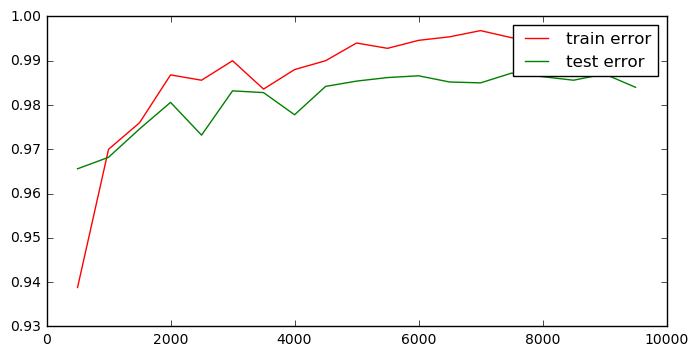

In [8]:
plt.figure(figsize=(8,4))
k=1
plt.plot(batch_iter[k:], train_error[k:], 'r', batch_iter[k:], test_error[k:], 'g');
plt.legend(["train error", "test error"]);

# Bidirectional RNN

In [9]:
biRNN_weights = tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
biRNN_biases = tf.Variable(tf.random_normal([n_classes]))

def BiRNN(x, weights, biases):
    lstm_backward_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
    lstm_forward_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)

    x = tf.transpose(x, [1, 0, 2]) # swap batch_size and n_steps
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(0, n_steps, x)

    outputs, _, _ = rnn.bidirectional_rnn(lstm_forward_cell, lstm_backward_cell, x, dtype=tf.float32)

    return tf.matmul(outputs[-1], weights) + biases
    
pred = BiRNN(x, biRNN_weights, biRNN_biases)

In [10]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [11]:
sess.run(tf.initialize_all_variables())

In [12]:
train_error, test_error, batch_iter = [], [], []
batch_size = 100
for i in range(10000):
    x_train, y_train = mnist.train.next_batch(batch_size)
    x_train = x_train.reshape((batch_size, n_steps, n_input))

    optimizer.run(feed_dict={x: x_train, y: y_train})
    
    if i % 500 == 0:
        x_train, y_train = mnist.train.next_batch(5000)
        x_train = x_train.reshape((5000, n_steps, n_input))
        acc_train = sess.run(acc, feed_dict={x: x_train, y: y_train})
        
        x_test, y_test = mnist.test.next_batch(5000)
        x_test = x_test.reshape((5000, n_steps, n_input))
        acc_test = sess.run(acc, feed_dict={x: x_test, y: y_test})
        
        train_loss = sess.run(cost, feed_dict={x: x_train, y: y_train})  
        test_loss = sess.run(cost, feed_dict={x: x_test, y: y_test})
        
        train_error.append(acc_train)
        test_error.append(acc_test)
        batch_iter.append(i)

        if i % 500 == 0:
            print("iter:{:5}, train_acc:{:.3f}, test_acc:{:.3f}, train_loss:{:.3f}, test_loss:{:.3f}".format(i, acc_train, acc_test, train_loss, test_loss))

        

iter:    0, train_acc:0.155, test_acc:0.160, train_loss:3.077, test_loss:3.167
iter:  500, train_acc:0.942, test_acc:0.966, train_loss:0.178, test_loss:0.104
iter: 1000, train_acc:0.974, test_acc:0.969, train_loss:0.087, test_loss:0.087
iter: 1500, train_acc:0.979, test_acc:0.974, train_loss:0.063, test_loss:0.076
iter: 2000, train_acc:0.986, test_acc:0.982, train_loss:0.043, test_loss:0.063
iter: 2500, train_acc:0.983, test_acc:0.980, train_loss:0.057, test_loss:0.066
iter: 3000, train_acc:0.990, test_acc:0.978, train_loss:0.035, test_loss:0.065
iter: 3500, train_acc:0.994, test_acc:0.987, train_loss:0.022, test_loss:0.046
iter: 4000, train_acc:0.991, test_acc:0.985, train_loss:0.028, test_loss:0.056
iter: 4500, train_acc:0.992, test_acc:0.986, train_loss:0.030, test_loss:0.049
iter: 5000, train_acc:0.990, test_acc:0.981, train_loss:0.029, test_loss:0.064
iter: 5500, train_acc:0.994, test_acc:0.985, train_loss:0.016, test_loss:0.046
iter: 6000, train_acc:0.995, test_acc:0.988, train_l

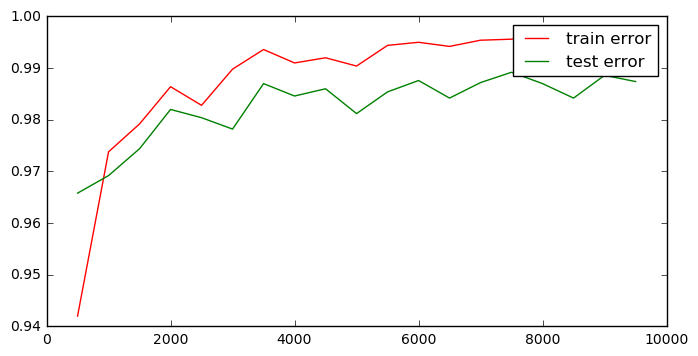

In [13]:
plt.figure(figsize=(8,4))
k=1
plt.plot(batch_iter[k:], train_error[k:], 'r', batch_iter[k:], test_error[k:], 'g');
plt.legend(["train error", "test error"]);

In [15]:
print(acc)

Tensor("Mean_3:0", shape=(), dtype=float32)
